# Natural Languge Processing

Restaurant Reviews

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

## Import the data

In [2]:
# download stop words...
nltk.download('stopwords')

# load the data...
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clean text and remove stop words

In [3]:
corpus = []
for i in range(0, 1000):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

# Creating the Bag of Words model

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values

### Create train / test

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Fit Naive Bayes

In [6]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[55 42]
 [12 91]]


### Display Accuracy

In [7]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.73


### Reclassify using TfidfVectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english', ngram_range=(1, 3), max_features = 20000)

X = vect.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

accuracy = classifier.score(X_test, y_test)
print("Accuracy: ", accuracy)

[[55 42]
 [15 88]]
Accuracy:  0.715


Note: Tfidf did not improve accuracy...use grid search to optimize the parameters

## Compare Algorithms

In [9]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Forest', RandomForestClassifier(n_estimators=100)))
models.append(('L SVM', LinearSVC(random_state=0)))

In [12]:
def printMetrics(name, cm):
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1Score = 2 * Precision * Recall / (Precision + Recall)

    print("%s: %f %f %f %f" % (name, accuracy, Precision, Recall, F1Score))
    
# evaluate each model
results = []
names = []

for name, model in models:
            
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    print('')
    print(name)
    print(cm)
    
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        
    results.append(cv_results)
    names.append(name)
        
    cm = confusion_matrix(y_test, y_pred)
    
    print('')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
        
    printMetrics(name, cm)


LR
[[87 10]
 [41 62]]

LR: 0.747000 (0.079253)
LR: 0.745000 0.896907 0.679688 0.773333

LDA
[[97  0]
 [79 24]]

LDA: 0.606000 (0.112889)
LDA: 0.605000 1.000000 0.551136 0.710623

KNN
[[ 97   0]
 [102   1]]

KNN: 0.503000 (0.155502)
KNN: 0.490000 1.000000 0.487437 0.655405

CART
[[81 16]
 [35 68]]

CART: 0.748000 (0.042143)
CART: 0.745000 0.835052 0.698276 0.760563

NB
[[55 42]
 [15 88]]

NB: 0.713000 (0.045177)
NB: 0.715000 0.567010 0.785714 0.658683

Forest
[[93  4]
 [54 49]]

Forest: 0.741000 (0.058043)
Forest: 0.710000 0.958763 0.632653 0.762295

L SVM
[[84 13]
 [35 68]]

L SVM: 0.783000 (0.039509)
L SVM: 0.760000 0.865979 0.705882 0.777778


### Display Comparison

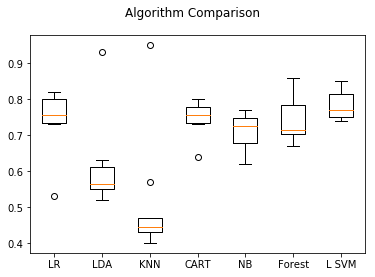

In [13]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()